In [4]:
# %matplotlib notebook

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import re
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.quant.quant_lfq_ion_DIA_diaPASEF import DIAQuantIonModulediaPASEF
from proteobench.io.params.alphadia import extract_params as extract_alphadia_params
from proteobench.io.params.diann import extract_params as extract_diann_params
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.msaid import extract_params as extract_msaid_params
from proteobench.io.params.spectronaut import read_spectronaut_settings as extract_spectronaut_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint
from plotly.subplots import make_subplots

In [2]:
module = DIAQuantIonModulediaPASEF("token")

In [3]:
data_path_diaPASEF = "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/"

In [ ]:
# maxquant_unfiltered = pd.read_csv(
#     "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence.txt", sep="\t"
# )
# maxquant_filtered = maxquant_unfiltered[maxquant_unfiltered["Q-value"] < 0.01]
# maxquant_filtered.to_csv(
#     "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence_filtered.txt",
#     sep="\t",
#     index=False,
# )

In [7]:
MAPPERS = {
    "FragPipe": {
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_01_11494 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_02_11500 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_03_11506 Intensity": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_01_11496 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_02_11502 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_03_11508 Intensity": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    },
    # "MSAID": {
    #     "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_01",
    #     "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_02",
    #     "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03.raw": "LFQ_Orbitrap_AIF_Condition_A_Sample_Alpha_03",
    #     "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_01",
    #     "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02",
    #     "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03.raw": "LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03",
    # },
}

In [8]:
def extract_result(file_paths, extract_params_func, datapoints, module, tool_name, comments):
    """Extract performance results using Proteobench benchmarking module"""
    all_datapoints = datapoints
    extracted_data = {}
    for name, (results, params) in file_paths.items():
        n_datapoints_before = len(all_datapoints)

        if "FragPipe" in name or "AlphaPept" in name:
            params = open(params, "rb")

        param_data = extract_params_func(params).__dict__
        results_performance, all_datapoints, result_df = module.benchmarking(
            results, tool_name, user_input=param_data, all_datapoints=all_datapoints
        )

        if "MaxQuant" in name:
            print("adding carbamidos to maxquant")
            print(results_performance)
            results_performance["precursor ion"] = results_performance["precursor ion"].apply(
                lambda x: x.replace("C", "C[Carbamidomethyl]")
            )

        extracted_data[name] = (results_performance, result_df)

        n_datapoints_after = len(all_datapoints)
        if n_datapoints_before == n_datapoints_after:
            print(f"Skipping {name} as no new datapoint was added.")
            continue
        comments.append(name)

    all_datapoints["comments"] = comments
    return extracted_data, all_datapoints, comments


def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_epsilon(v, min_quant=min_quant) for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [filter_df_numquant_nr_prec(v, min_quant=min_quant) for v in all_datapoints["results"]]
    return all_datapoints


def plot_performance_metrics(file_paths, min_quant=3, module=DIAQuantIonModulediaPASEF("token"), metric="Median"):
    """Plot performance metrics"""
    datapoints = pd.DataFrame()
    results = {}
    comments = []
    for tool, paths in file_paths.items():
        extract_func = globals()[f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '')}_params"]
        tool_results, datapoints, comments = extract_result(paths, extract_func, datapoints, module, tool, comments)
        results[tool] = tool_results
    datapoints = prepare_datapoints(datapoints, min_quant=min_quant)
    plot = PlotDataPoint.plot_metric(datapoints, metric=metric)
    return plot, results


def plot_performance_metrics_all_filters(
    file_paths, x_range, y_range, metric="Median", module=DIAQuantIonModulediaPASEF("token")
):
    """Plot performance metrics"""
    datapoints = pd.DataFrame()
    results = {}
    comments = []
    for tool, paths in file_paths.items():
        extract_func = globals()[
            f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '').replace('custom', 'sage').replace('peaks', 'sage').replace('msangel', 'sage').replace('prolinestudio', 'proline')}_params"
        ]
        tool_results, datapoints, comments = extract_result(paths, extract_func, datapoints, module, tool, comments)
        results[tool] = tool_results

    plots = []
    for min_quant in range(1, 7):
        datapoints = prepare_datapoints(datapoints, min_quant=min_quant)
        plot = PlotDataPoint.plot_metric(datapoints, metric=metric)
        plot.update_layout(xaxis=dict(range=x_range), yaxis=dict(range=y_range))
        plots.append(plot)

    combined_fig = make_subplots(rows=2, cols=3, subplot_titles=[f"Min. quantified ions: {i}" for i in range(1, 7)])

    positions = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]

    for fig, (r, c) in zip(plots, positions):
        for trace in fig.data:
            combined_fig.add_trace(trace, row=r, col=c)

            combined_fig.update_xaxes(range=x_range, row=r, col=c)
            combined_fig.update_yaxes(range=y_range, row=r, col=c)

    combined_fig.update_layout(height=800, width=1200)

    # remove duplicate legend items
    names = set()
    combined_fig.for_each_trace(
        lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name)
    )

    return combined_fig, results


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None):
    performance_dict = {}
    for name, data in results.items():
        for name, data in data.items():
            data = data[0]
            if mapper != None:
                data = data.rename(columns=mappers[mapper])
            elif name in mappers:
                tool_mapper = mappers[name]
                data = data.rename(columns=tool_mapper)

            data.columns = [x.replace(".mzML", "") for x in data.columns]
            performance_dict[name] = data
    return performance_dict

In [9]:
# Global style settings
sns.set_style("white")
sns.despine()
palette = ["#ffdfba", "#3b6f90"]


# Function to get the number of quantified precursors
def get_raw_file_prec_n_species(performance_df, species):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = [
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_01_11494",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_02_11500",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_03_11506",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_01_11496",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_02_11502",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_03_11508",
    ]
    return {column: performance_df_species[column].notna().sum() for column in columns_of_interest}


# Function to create the horizontal dot plot with error bars
def prec_n_dotplot_species(performance_df, species, ax, df_index=None, species_index=None):
    prec_n_dict = get_raw_file_prec_n_species(performance_df, species)
    data = {"Condition": ["A"] * 3 + ["B"] * 3, "Values": [prec_n_dict[col] for col in prec_n_dict]}

    # Convert to DataFrame for easier aggregation
    data_df = pd.DataFrame(data)

    # Calculate mean and standard deviation for each condition
    mean_values = data_df.groupby("Condition")["Values"].mean()
    std_values = data_df.groupby("Condition")["Values"].std()

    # Plot individual data points
    sns.stripplot(
        y="Condition", x="Values", data=data_df, ax=ax, palette=palette, size=8, color="black", jitter=False, alpha=0.5
    )

    # Plot mean with error bars
    for i, condition in enumerate(["A", "B"]):
        ax.errorbar(
            mean_values[condition],
            i,
            xerr=std_values[condition],
            fmt="o",
            color=palette[i],
            markersize=8,
            capsize=5,
            capthick=2,
            elinewidth=2,
        )

    # Set y-axis label only for the leftmost dot plot

    ax.set_ylabel("")
    if species_index != 0:
        ax.tick_params(axis="y", which="both", left=False, labelleft=False)

    # Set x-axis label only on the last row of dot plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Number of Quantified Precursors", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the KDE plot
def plot_logI_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["log_Intensity_mean_A", "log_Intensity_mean_B"]
    for i, column in enumerate(columns_of_interest):
        sns.kdeplot(performance_df_species[column], ax=ax, color=palette[i], linewidth=2, fill=True)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of KDE plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Log(Intensity)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)

    # Add grid lines and remove vertical spines
    ax.xaxis.grid(True, linestyle="--", alpha=0.5)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Function to create the boxplot
def plot_CV_distribution_species(performance_df, species, ax, df_index=None, species_index=None):
    performance_df_species = performance_df[performance_df["species"] == species]
    columns_of_interest = ["CV_A", "CV_B"]
    melted_df = performance_df_species[columns_of_interest].melt(var_name="Condition", value_name="CV")
    melted_df["Condition"] = melted_df["Condition"].replace({"CV_A": "A", "CV_B": "B"})
    sns.boxplot(x="CV", y="Condition", data=melted_df, ax=ax, orient="h", palette=palette, linewidth=1.5)

    # Remove y-axis label and ticks
    ax.set_ylabel("")
    ax.set_yticks([])

    # Set x-axis label only on the last row of box plots
    if df_index == num_dfs - 1:
        if species_index == 1:
            ax.set_xlabel("Coefficient of Variation (CV)", fontsize=10)
        else:
            ax.set_xlabel("")
    else:
        ax.set_xlabel("")

    # Optional title for each species in the first row
    if df_index == 0:
        ax.set_title(f"{species}", fontsize=12, fontweight="bold")

    ax.tick_params(axis="x", labelsize=9)
    ax.xaxis.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)


# Combined function to generate all plots for a dictionary of DataFrames
def combined_species_plots(performance_df_dict):
    global num_dfs
    num_dfs = len(performance_df_dict)
    max_species_count = max(len(df["species"].unique()) for df in performance_df_dict.values())

    # Adjusted figure height
    fig, axs = plt.subplots(
        num_dfs,
        max_species_count * 3,
        figsize=(5 * max_species_count * 3, 1 * num_dfs),  # Adjust height as needed
        sharex="col",
        gridspec_kw={"wspace": 0, "hspace": 0.7, "left": 0},  # Adjust spacing between plots
    )

    if num_dfs == 1:
        axs = [axs]

    for df_index, (name, performance_df) in enumerate(performance_df_dict.items()):
        species_list = performance_df["species"].unique()

        for species_index, species in enumerate(species_list):
            # Divide columns into groups for each plot type
            dot_ax = axs[df_index][species_index]
            kde_ax = axs[df_index][species_index + max_species_count]
            box_ax = axs[df_index][species_index + 2 * max_species_count]

            # Create individual plots
            prec_n_dotplot_species(performance_df, species, dot_ax, df_index, species_index)
            plot_logI_distribution_species(performance_df, species, kde_ax, df_index, species_index)
            plot_CV_distribution_species(performance_df, species, box_ax, df_index, species_index)

            # Ensure KDE plots share y-axis within the row
            if species_index > 0:
                kde_ax.sharey(axs[df_index][max_species_count])

    # Adjust layout further to reduce whitespace if necessary
    plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
    plt.tight_layout()  # Final adjustment for plot layout
    return fig

<Figure size 640x480 with 0 Axes>

In [10]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(tools)) | (row_sums == len(tools) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(tools)
    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        data = data.merge(df[["precursor ion", "epsilon"]], left_on="id", right_on="precursor ion", how="left")
        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):

    # Draw the stripplot with a custom palette
    sns.boxplot(data=boxplot_data, x="workflow", y="epsilon", hue="quantified by", ax=ax, showfliers=False, linewidth=1)
    # sns.violinplot(data=boxplot_data, x="tool", y="epsilon", hue = "unique or all", ax=ax, inner=None, linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
    # rotate
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # make y label bigger
    ax.yaxis.label.set_size(12)

    # Add a tighter layout for better spacing
    plt.tight_layout()


def strip_peptidoform(peptidoform):
    no_mods = re.sub(r"\[.*?\]", "", peptidoform)
    no_mods = no_mods.replace("-", "")
    return no_mods


def filter_df(df):
    df["precursor ion"] = df["precursor ion"].apply(strip_peptidoform)
    df.drop_duplicates(subset="precursor ion", inplace=True, keep="first")
    return df


def plot_upset_and_boxplot(df_dict, mapper, stripped=False):

    if stripped:
        df_dict_copy = df_dict.copy()
        df_dict_copy = {key: filter_df(val) for key, val in df_dict_copy.items()}

    else:
        df_dict_copy = df_dict.copy()

    boxplotdata = upsetplot_from_df_dict(df_dict_copy)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    # plot upset plot
    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(boxplotdata, subset_size="count", include_empty_subsets=False, sort_categories_by="input")
    upset.style_subsets(min_degree=1, facecolor="#3274A1")
    upset.style_subsets(min_degree=2, facecolor="black")
    upset.style_subsets(min_degree=6, facecolor="#E1812C")
    upset.plot(fig=fig)
    ax_upset.grid(False)

    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])

    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    # color the same as boxplot

    # plot boxplot, sorted the same way as the upset plot
    boxplotdata = boxplotdata.reset_index()

    # this needs to be adapted to the number of tools... currently hardcoded :( sorry
    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

    # drop all ions that are neither all or unique
    boxplotdata = boxplotdata.dropna(subset=["eval"])
    boxplotdata.to_csv("boxplotdata.csv")
    epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
    important_cols = epsilon_cols + ["eval"]
    boxplotdata = boxplotdata[important_cols]

    boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
    boxplotdata = boxplotdata.sort_values("eval")

    # turn to long format for plotting
    boxplotdata_final = pd.DataFrame()
    for col in epsilon_cols:
        temp = boxplotdata[["eval", col]]
        tool = col.split("_epsilon")[0]
        ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
        ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
        ions["workflow"] = tool
        ions = ions.rename(columns={col: "epsilon"})
        ions = ions.drop(columns=["eval"]).reset_index(drop=True)
        boxplotdata_final = pd.concat([boxplotdata_final, ions])

    boxplotdata_final.reset_index(drop=True, inplace=True)

    # Set the style
    fig, box_ax = plt.subplots(figsize=(10, 6))
    fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
    plt.show()
    return fig, fig_box


def plot_upset_and_boxplot_all_filters(df_dict, mapper):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {key: value[value["nr_observed"] >= i] for key, value in df_dict.items()}

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)
        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata, subset_size="count", include_empty_subsets=False, sort_categories_by="input"
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=6, facecolor="#E1812C")
        upset.plot(fig=fig)
        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        # this needs to be adapted to the number of tools... currently hardcoded :( sorry)
        boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()
        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # drop all ions that are neither all or unique
        boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        plt.title("Min. quantified ions: " + str(i))
        plt.show()
    return fig, fig_box

In [11]:
def filter_file_upset_data(data, files):
    # Filter the data so that only subsets are plotted that contain sequences from all files, from all-but-one file, or from only one file
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    filtered_data = data_index_reset[(row_sums == len(files)) | (row_sums == len(files) - 1) | (row_sums == 1)]
    filtered_data = filtered_data.set_index(files)
    return filtered_data


def plot_quant_prec_overlap_files(performance_df, column="precursor ion"):
    relevant_columns = [
        "precursor ion",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_01_11494",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_02_11500",
        "ttSCP_diaPASEF_Condition_A_Sample_Alpha_03_11506",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_01_11496",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_02_11502",
        "ttSCP_diaPASEF_Condition_B_Sample_Alpha_03_11508",
    ]
    performance_df_filtered = performance_df[relevant_columns]
    performance_df_filtered = performance_df_filtered.set_index(column)
    performance_df_filtered = performance_df_filtered.notna()
    performance_df_sets = {
        column: set(performance_df_filtered[performance_df_filtered[column]].index)
        for column in performance_df_filtered.columns
    }
    upset_data = upsetplot.from_contents(performance_df_sets)
    upset_data_filtered = filter_file_upset_data(upset_data, relevant_columns[1:])
    upset = upsetplot.UpSet(upset_data_filtered, subset_size="count", include_empty_subsets=False, show_counts=False)
    upset.plot()

# Overview figure, all runs

In [12]:
file_paths_overview = {
    "AlphaDIA": {
        "AlphaDIA": (
            data_path_diaPASEF + "alphadia_1.10_defaultMBR/precursors.tsv",
            data_path_diaPASEF + "alphadia_1.10_defaultMBR/log.txt",
        ),
        "AlphaDIA Transfer": (
            data_path_diaPASEF + "alphadia_1.10_defaultMBRTransfer/precursors.tsv",
            data_path_diaPASEF + "alphadia_1.10_defaultMBRTransfer//log.txt",
        ),
    },
    "DIA-NN": {
        "DIA-NN": (
            data_path_diaPASEF + "diann_1.9.2_default/report.tsv",
            data_path_diaPASEF + "diann_1.9.2_default/report.log.txt",
        ),
        "1.7.16": (
            data_path_diaPASEF + "diann_1.7.16_default/report.tsv",
            data_path_diaPASEF + "diann_1.7.16_default/report.log.txt",
        ),
        "1.8": (
            data_path_diaPASEF + "diann_1.8_default/report.tsv",
            data_path_diaPASEF + "diann_1.8_default/report.log.txt",
        ),
        "1.9.1": (
            data_path_diaPASEF + "diann_1.9.1_default/report.tsv",
            data_path_diaPASEF + "diann_1.9.1_default/report.log.txt",
        ),
        "Conservative NN": (
            data_path_diaPASEF + "diann_1.9.2_conservativenn/report.tsv",
            data_path_diaPASEF + "diann_1.9.2_conservativenn/report.log.txt",
        ),
        "Linear NN": (
            data_path_diaPASEF + "diann_1.9.2_linearclassifier/report.tsv",
            data_path_diaPASEF + "diann_1.9.2_linearclassifier/report.log.txt",
        ),
        "High Accuracy": (
            data_path_diaPASEF + "diann_1.9.2_highacc/report.tsv",
            data_path_diaPASEF + "diann_1.9.2_highacc/report.log.txt",
        ),
        "Legacy Quant": (
            data_path_diaPASEF + "diann_1.9.2_legacy_quant/report.tsv",
            data_path_diaPASEF + "diann_1.9.2_legacy_quant/report.log.txt",
        ),
    },
    "FragPipe (DIA-NN quant)": {
        "FragPipe": (
            data_path_diaPASEF + "Fragpipe_22_DiaPASEF_Speclib_Quant_default/diann-output/report.tsv",
            data_path_diaPASEF + "Fragpipe_22_DiaPASEF_Speclib_Quant_default/fragpipe.workflow",
        ),
        "FragPipe different peplen": (
            data_path_diaPASEF + "Fragpipe_22_DiaPASEF_Speclib_Quant_Other/diann-output/report.tsv",
            data_path_diaPASEF + "Fragpipe_22_DiaPASEF_Speclib_Quant_Other/fragpipe.workflow",
        ),
    },
    # "MaxQuant": {
    #     "MaxQuant (filtered)": (
    #         "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence_filtered.txt",
    #         "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/mqpar.xml",
    #     ),
    # },
    # "Spectronaut": {
    #     "Spectronaut": (
    #         "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_Report_BGS Factory Report (Normal).tsv",
    #         "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
    #     ),
    # },
}

In [13]:
plot, results = plot, results = plot_performance_metrics_all_filters(
    file_paths_overview, x_range=[0, 1], y_range=[0, 140000], metric="Mean"
)

ValueError: 8 is not in list

In [132]:
plot

# Default settings, compare search engines

In [133]:
file_paths_general = {
    "AlphaDIA": {
        "AlphaDIA": (
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_default_correct_peplen/precursors.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_default_correct_peplen/log.txt",
        ),
        "AlphaDIA two-step": (
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_second_search/precursors.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/alphadia_second_search/log.txt",
        ),
    },
    "DIA-NN": {
        "DIA-NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        )
    },
    # "FragPipe": {
    #     "FragPipe": (
    #         "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe_ionquant_22.0_default/combined_ion.tsv",
    #         "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe_ionquant_22.0_default/fragpipe.workflow",
    #     )
    # },
    "FragPipe (DIA-NN quant)": {
        "FragPipe": (
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe-diann-22.0_default_good_peplen/diann-output/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/fragpipe-diann-22.0_default_good_peplen/fragpipe.workflow",
        )
    },
    "MaxQuant": {
        # "MaxQuant": (
        #     "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence.txt",
        #     "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/mqpar.xml",
        # ),
        "MaxQuant (filtered)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/combined/txt/evidence_filtered.txt",
            "/mnt/d/Proteobench_manuscript_data/run_output/maxquant2.6.3.0_default/mqpar.xml",
        ),
    },
    "MSAID": {
        "MSAID": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/Proteobench_default_actual_details.csv",
        )
    },
}

In [134]:
plot, results = plot_performance_metrics(file_paths_general)

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
                          precursor ion  log_Intensity_mean_A   
0      AAAAAAAAAAAPPAPPEGASPGDSARQK|Z=3                   NaN  \
1                      AAAAAAAAAVSR|Z=2                   NaN   
2         AAAAAAAAVPSAGPAGPAPTSAAGR|Z=3                   NaN   
3                       AAAAAAALQAK|Z=2             26.439734   
4                      AAAAAAGSGTPR|Z=2             24.095758   
...                                 ...                   ...   
63763             YYVPPGIPTNDTSNLER|Z=2             19.689138   
63764                  YYVSPSDLLDDK|Z=2             22.098766   
63765                  YYVTIIDAPGHR|Z=2             30.026480   
63766                  YYVTIIDAPGHR|Z=3             30.721069   
63767              YYYAVVDCDSPETASK|Z=2             21.801350   

       log_I

In [135]:
plot.write_image("/mnt/c/Users/robbe/Work/ProteoBench/figures_manuscript/overview_performance_metrics.svg")

In [136]:
plot, results = plot_performance_metrics(file_paths_general, metric="Mean")

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
                          precursor ion  log_Intensity_mean_A   
0      AAAAAAAAAAAPPAPPEGASPGDSARQK|Z=3                   NaN  \
1                      AAAAAAAAAVSR|Z=2                   NaN   
2         AAAAAAAAVPSAGPAGPAPTSAAGR|Z=3                   NaN   
3                       AAAAAAALQAK|Z=2             26.439734   
4                      AAAAAAGSGTPR|Z=2             24.095758   
...                                 ...                   ...   
63763             YYVPPGIPTNDTSNLER|Z=2             19.689138   
63764                  YYVSPSDLLDDK|Z=2             22.098766   
63765                  YYVTIIDAPGHR|Z=2             30.026480   
63766                  YYVTIIDAPGHR|Z=3             30.721069   
63767              YYYAVVDCDSPETASK|Z=2             21.801350   

       log_I

In [137]:
plot.write_image("/mnt/c/Users/robbe/Work/ProteoBench/figures_manuscript/overview_performance_metrics_mean.svg")

In [138]:
plot, results = plot_performance_metrics_all_filters(
    file_paths_general, x_range=[0, 0.7], y_range=[0, 100000], metric="Median"
)

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
                          precursor ion  log_Intensity_mean_A   
0      AAAAAAAAAAAPPAPPEGASPGDSARQK|Z=3                   NaN  \
1                      AAAAAAAAAVSR|Z=2                   NaN   
2         AAAAAAAAVPSAGPAGPAPTSAAGR|Z=3                   NaN   
3                       AAAAAAALQAK|Z=2             26.439734   
4                      AAAAAAGSGTPR|Z=2             24.095758   
...                                 ...                   ...   
63763             YYVPPGIPTNDTSNLER|Z=2             19.689138   
63764                  YYVSPSDLLDDK|Z=2             22.098766   
63765                  YYVTIIDAPGHR|Z=2             30.026480   
63766                  YYVTIIDAPGHR|Z=3             30.721069   
63767              YYYAVVDCDSPETASK|Z=2             21.801350   

       log_I

In [139]:
plot

In [140]:
plot, results = plot_performance_metrics_all_filters(
    file_paths_general, x_range=[0, 0.8], y_range=[0, 100000], metric="Mean"
)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
adding carbamidos to maxquant
                          precursor ion  log_Intensity_mean_A   
0      AAAAAAAAAAAPPAPPEGASPGDSARQK|Z=3                   NaN  \
1                      AAAAAAAAAVSR|Z=2                   NaN   
2         AAAAAAAAVPSAGPAGPAPTSAAGR|Z=3                   NaN   
3                       AAAAAAALQAK|Z=2             26.439734   
4                      AAAAAAGSGTPR|Z=2             24.095758   
...                                 ...                   ...   
63763             YYVPPGIPTNDTSNLER|Z=2             19.689138   
63764                  YYVSPSDLLDDK|Z=2             22.098766   
63765                  YYVTIIDAPGHR|Z=2             30.026480   
63766                  YYVTIIDAPGHR|Z=3             30.721069   
63767              YYYAVVDCDSPETASK|Z=2             21.801350   

       log_I

## Intersection between all the search engines: How do the unique quantifications perform?

In [141]:
%matplotlib inline

In [142]:
# TODO: find out how UpsetPlot orders its data so as not to hardcode this
all_tools_mapper = {
    "[True, False, False, False, False, False]": "AlphaDIA",
    "[False, True, False, False, False, False]": "AlphaDIA two-step",
    "[False, False, True, False, False, False]": "DIA-NN",
    "[False, False, False, True, False, False]": "FragPipe",
    "[False, False, False, False, True, False]": "MaxQuant (filtered)",
    "[False, False, False, False, False, True]": "MSAID",
    "[True, True, True, True, True, False]": "all but MSAID",
    "[True, True, True, True, False, True]": "all but MaxQuant (filtered)",
    "[True, True, True, False, True, True]": "all but FragPipe",
    "[True, True, False, True, True, True]": "all but DIA-NN",
    "[True, False, True, True, True, True]": "all but AlphaDIA two-step",
    "[False, True, True, True, True, True]": "all but AlphaDIA",
    "[True, True, True, True, True, True]": "all",
}

In [143]:
results

{'AlphaDIA': {'AlphaDIA': (                         precursor ion  log_Intensity_mean_A   
   0                     AAAAAAAAAVSR|Z=2                   NaN  \
   1                      AAAAAAALQAK|Z=1             34.739424   
   2                      AAAAAAALQAK|Z=2             34.739424   
   3                       AAAAADLANR|Z=2             28.624468   
   4                  AAAAALSQQQSLQER|Z=2             26.020176   
   ...                                ...                   ...   
   71466            [Acetyl]-VDMMDLPR|Z=2             30.078537   
   71467           [Acetyl]-VDREQLVQK|Z=2             33.646866   
   71468         [Acetyl]-VDYYEVLGVQR|Z=2                   NaN   
   71469            [Acetyl]-VEADRPGK|Z=2             33.657813   
   71470  [Acetyl]-VNPTVFFDIAVDGEPLGR|Z=2             36.228202   
   
          log_Intensity_mean_B  log_Intensity_std_A  log_Intensity_std_B   
   0                 26.861395                  NaN                  NaN  \
   1            

In [144]:
performance_df_dict = prepare_performance_dict(results, mapper=None)

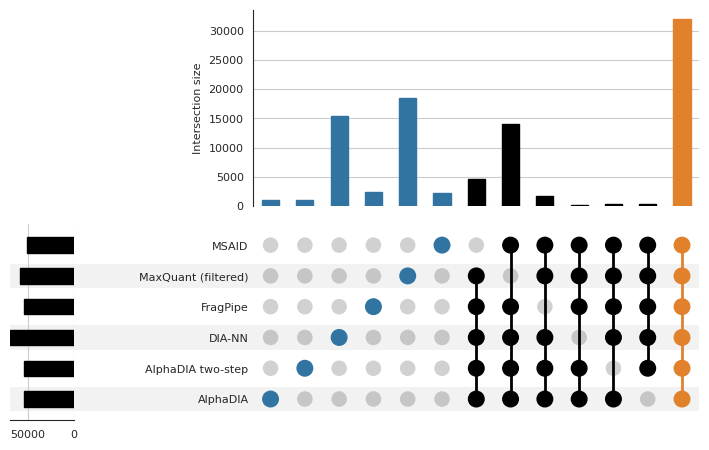

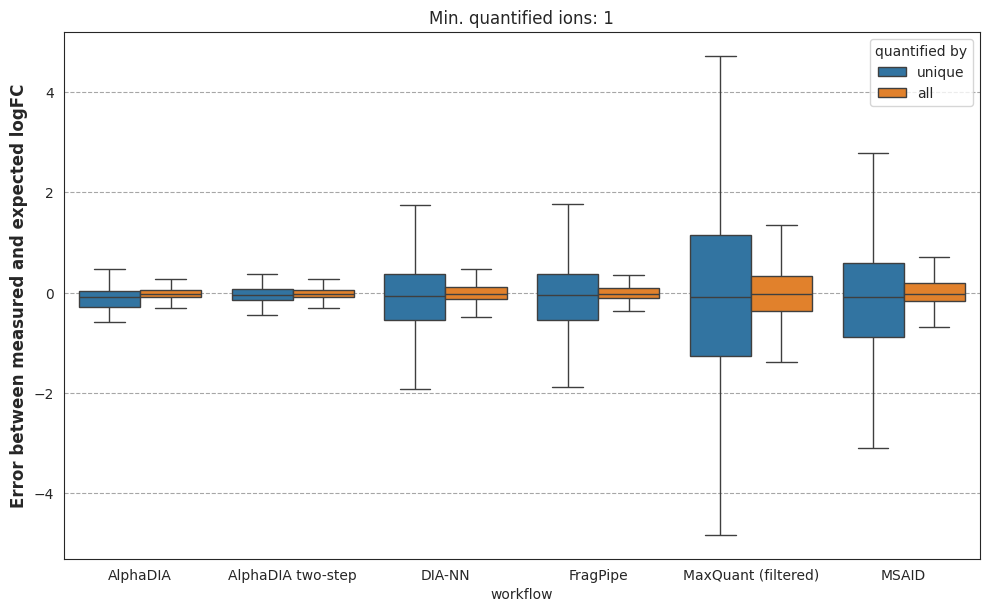

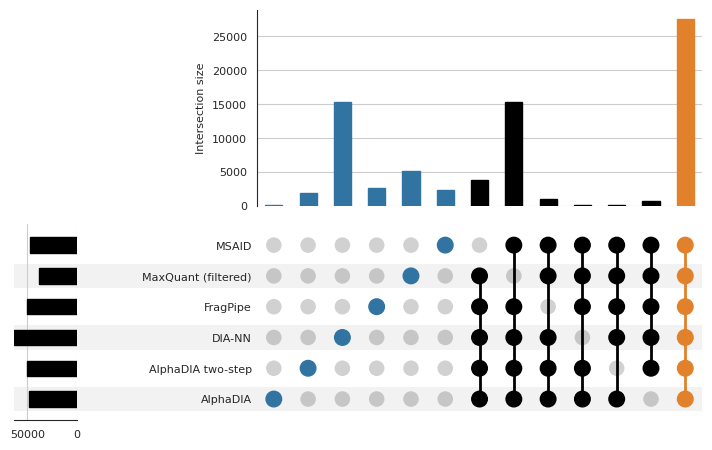

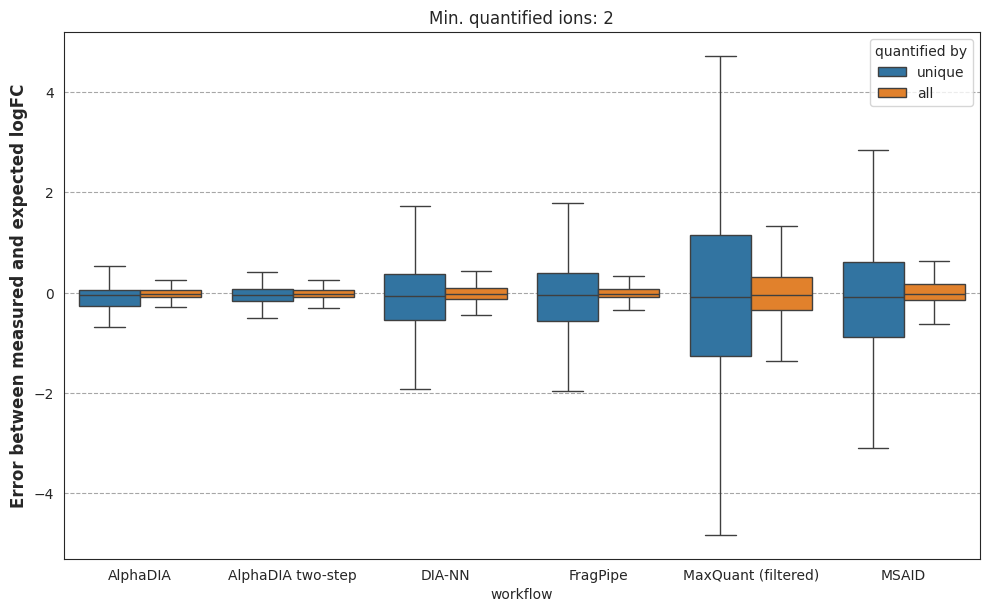

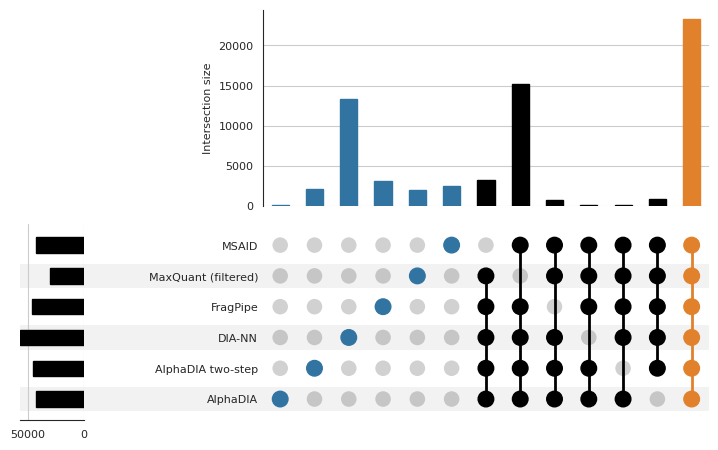

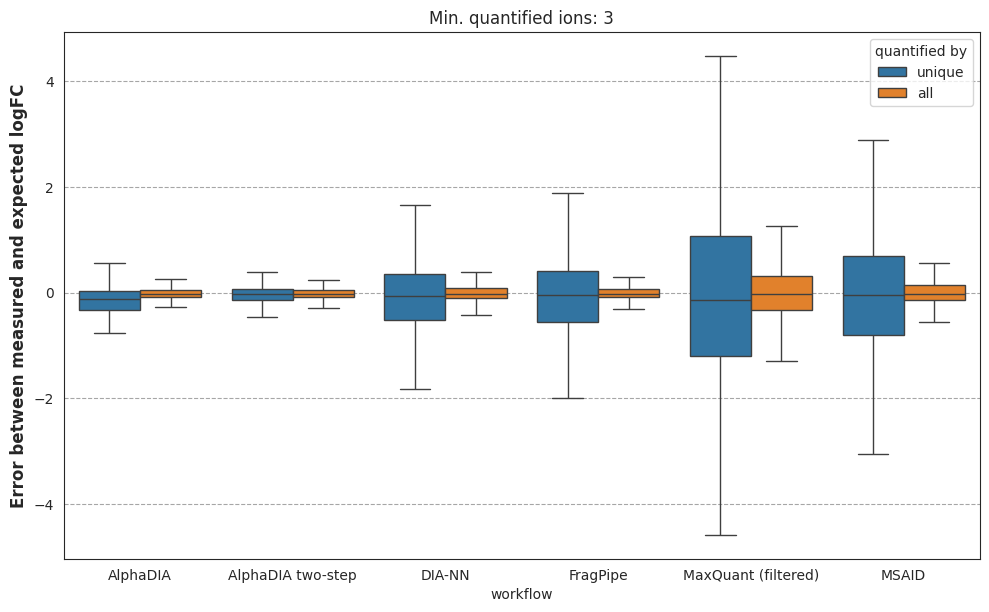

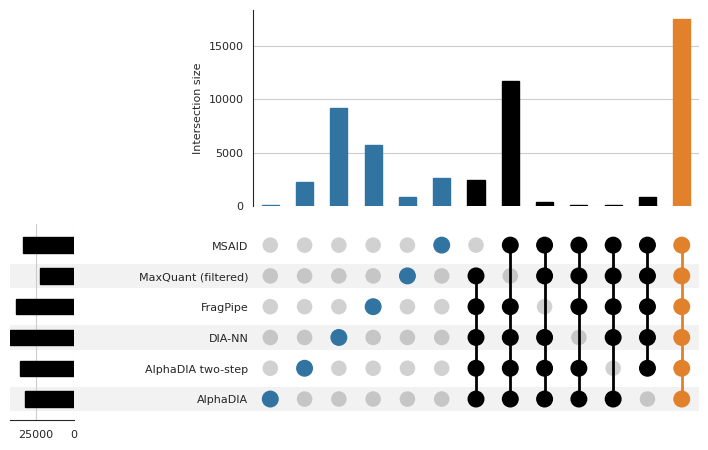

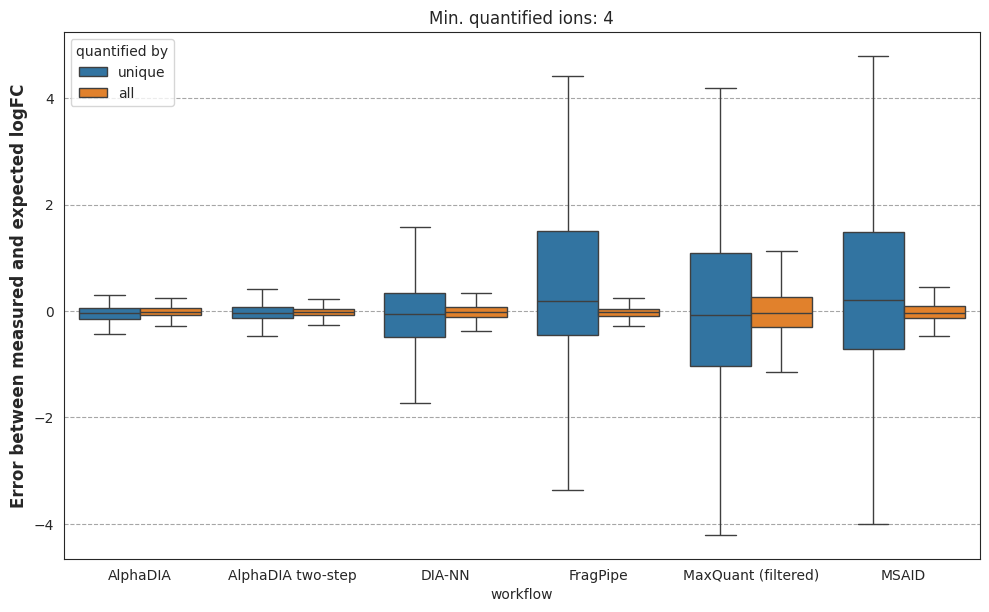

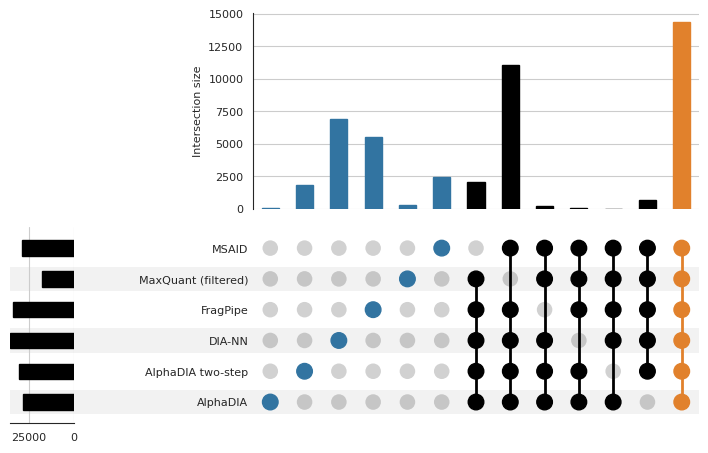

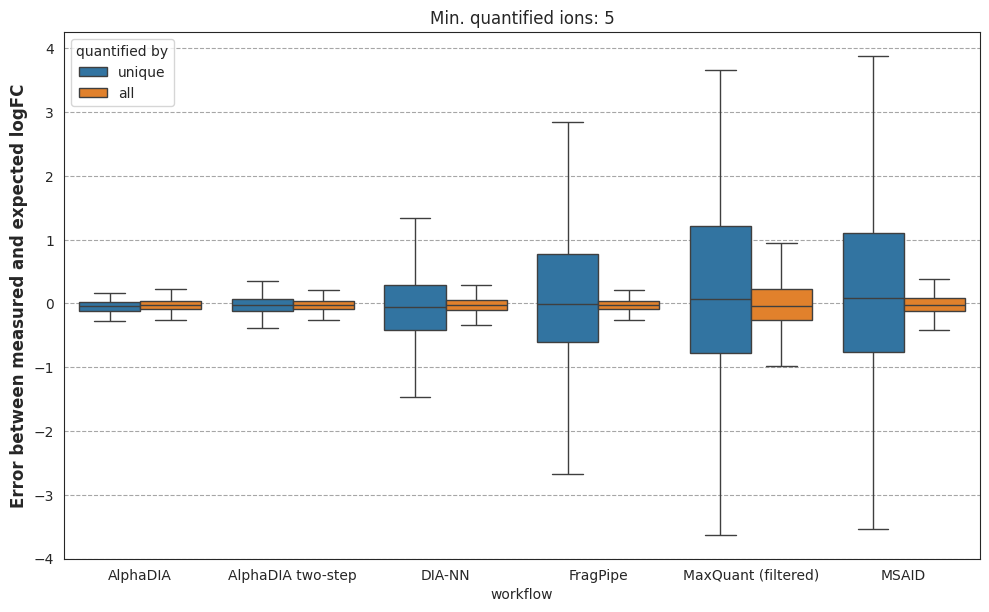

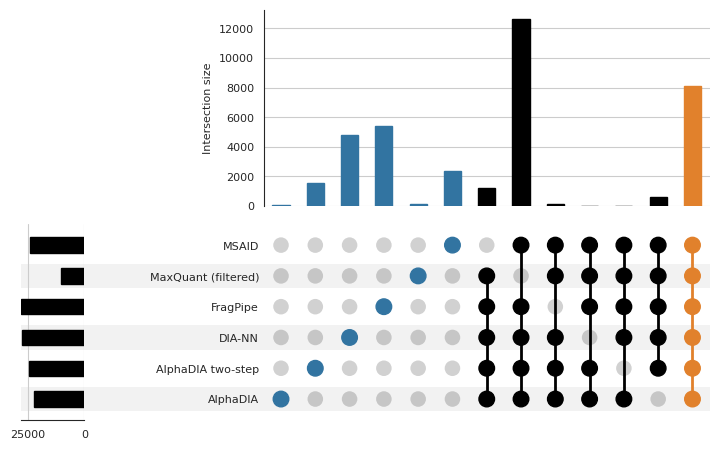

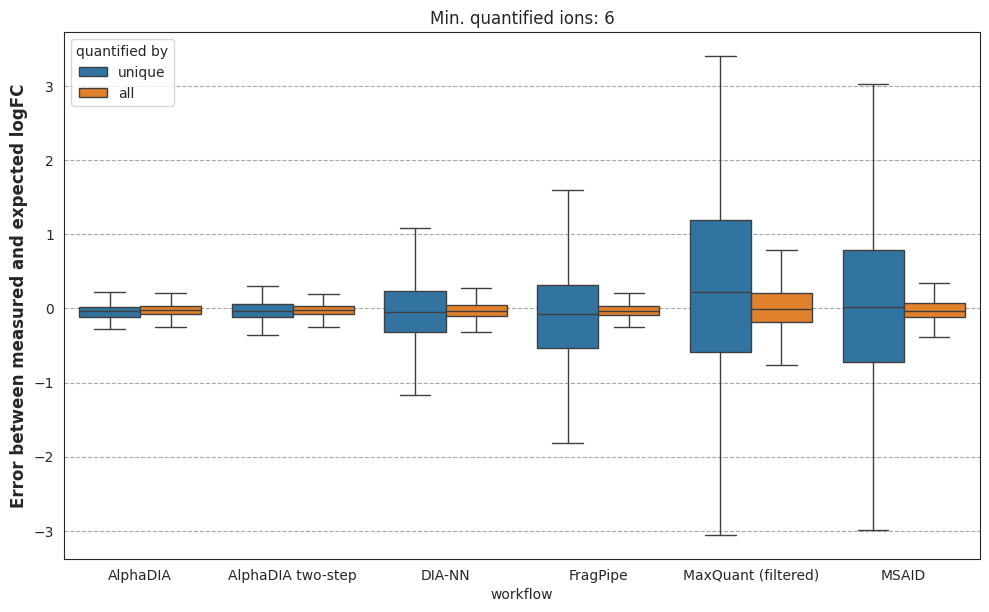

In [145]:
fig = plot_upset_and_boxplot_all_filters(performance_df_dict, all_tools_mapper)

# Intersection between DIA-NN and AlphaDIA (two-step): Are the unique quants from DIA-NN accurately quantified?

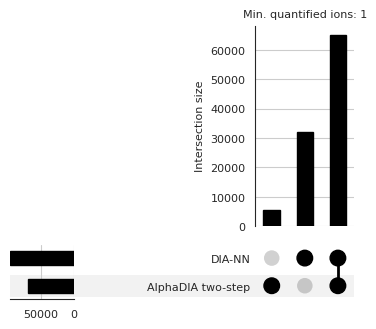

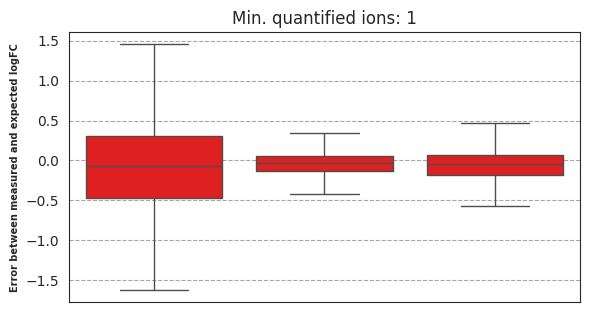

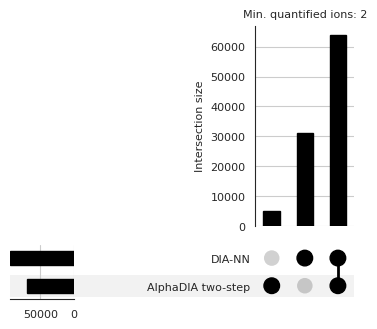

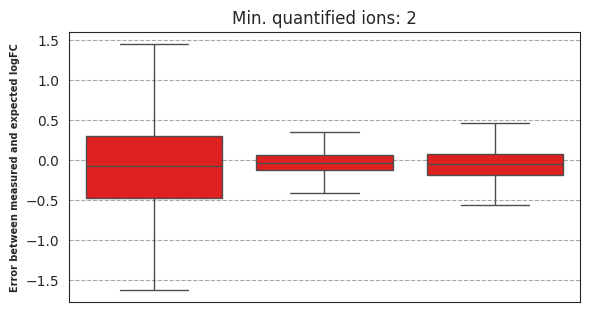

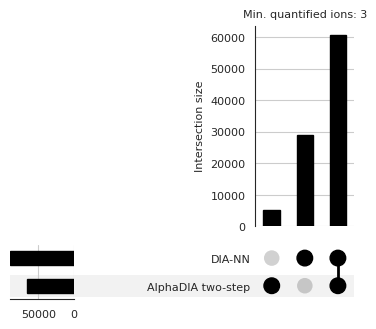

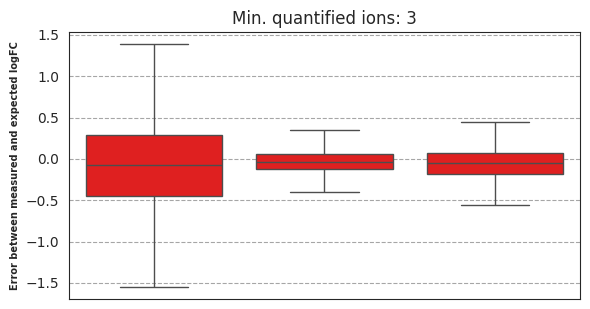

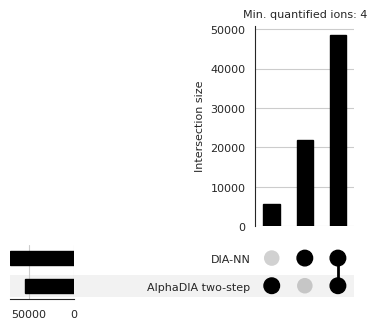

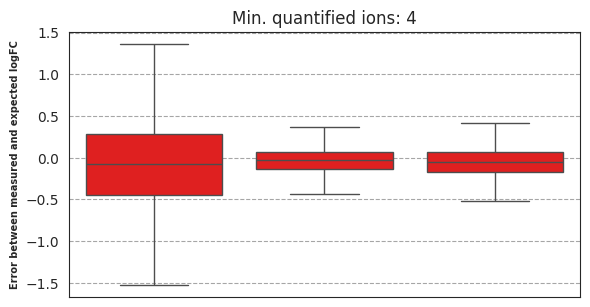

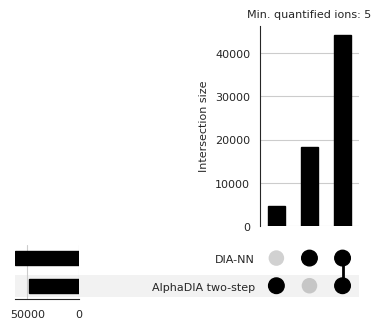

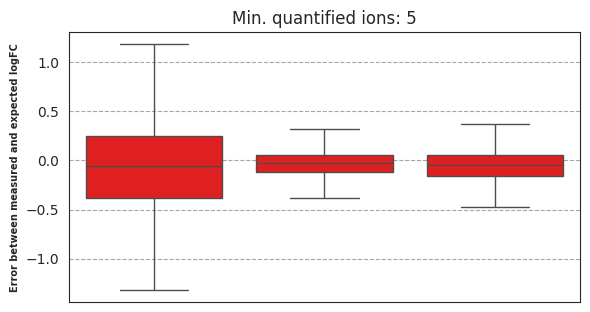

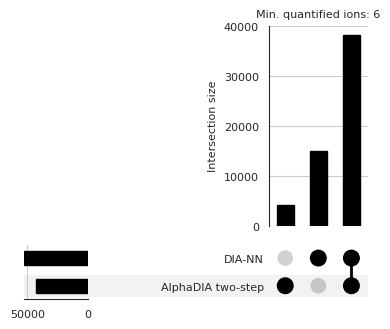

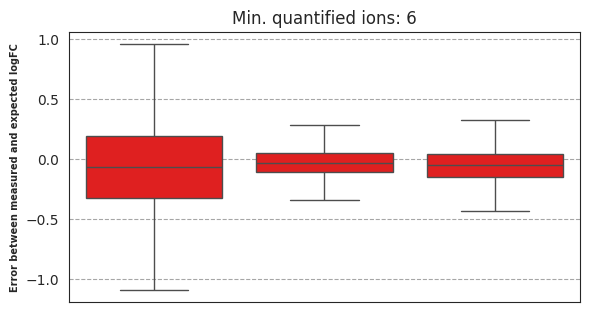

In [170]:
diann_alphadia_performance_dict = {
    "AlphaDIA two-step": performance_df_dict["AlphaDIA two-step"],
    "DIA-NN": performance_df_dict["DIA-NN"],
}
diann_alphadia_mapper = {"[False, True]": "AlphaDIA two-step", "[True, False]": "DIA-NN", "[True, True]": "all"}
fig_diann_alphadia = plot_upset_and_boxplot_all_filters(diann_alphadia_performance_dict, diann_alphadia_mapper)

In [171]:
# Find the overlap between the quantified precursors
diann_alphadia_merged = pd.merge(
    performance_df_dict["DIA-NN"],
    performance_df_dict["AlphaDIA two-step"],
    on="precursor ion",
    how="inner",
    suffixes=("_diann", "_alphadia"),
)

Text(0.5, 1.0, 'Quantitative accuracy of DIANN and AlphaDIA two-step for precursors quantified by both tools')

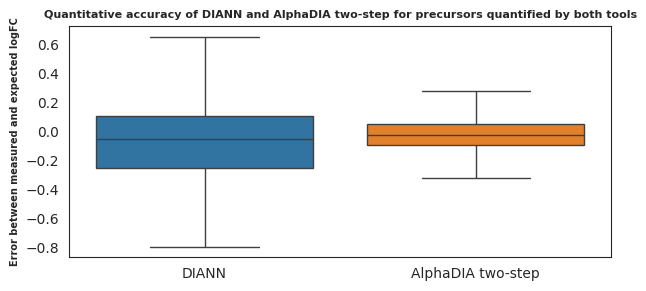

In [172]:
# Plot 2 boxplots of the epsilons of DIANN and AlphaDIA for the overlapping precursors
epsilons = diann_alphadia_merged[["epsilon_diann", "epsilon_alphadia"]]
epsilons.columns = ["DIANN", "AlphaDIA two-step"]
fig, ax = plt.subplots(figsize=(7, 3))

sns.boxplot(data=epsilons, ax=ax, showfliers=False, linewidth=1)
ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
ax.set_title(
    "Quantitative accuracy of DIANN and AlphaDIA two-step for precursors quantified by both tools",
    fontsize=8,
    fontweight="bold",
)

# DIA-NN: Differences between versions

In [41]:
file_paths_versioning = {
    "DIA-NN": {
        "1.7.16": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.7.16_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.7.16_default/report.log.txt",
        ),
        "1.8": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.8_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.8_default/report.log.txt",
        ),
        "1.9.1": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.1_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.1_default/report.log.txt",
        ),
        "1.9.2": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        ),
    }
}

In [42]:
plot, results_versioning = plot_performance_metrics(file_paths_versioning)

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [44]:
plot.write_image("/mnt/c/Users/robbe/Work/ProteoBench/figures_manuscript/versioning_performance_metrics_AIF.svg")

In [45]:
plot, results_versioning = plot_performance_metrics_all_filters(
    file_paths_versioning, x_range=[0, 0.3], y_range=[0, 140000]
)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [46]:
plot, results_versioning = plot_performance_metrics_all_filters(
    file_paths_versioning, x_range=[0, 0.8], y_range=[0, 140000], metric="Mean"
)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [47]:
performance_df_dict_versioning = prepare_performance_dict(results_versioning)
# combined_species_plots(performance_df_dict_versioning)

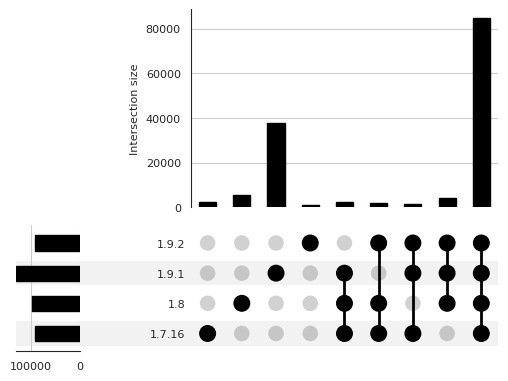

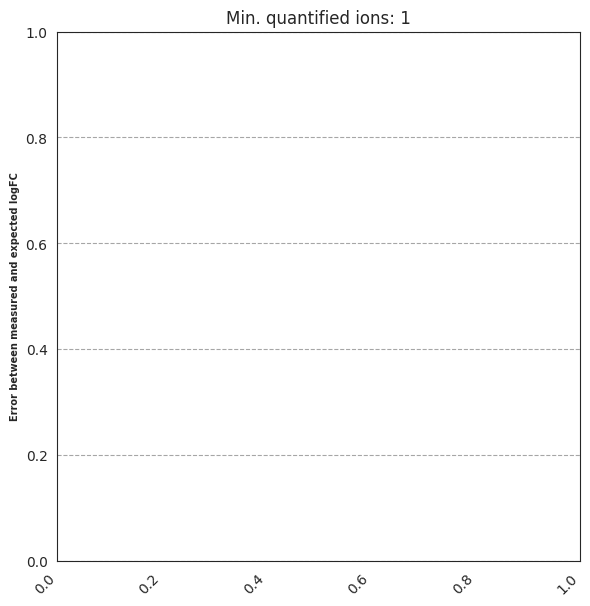

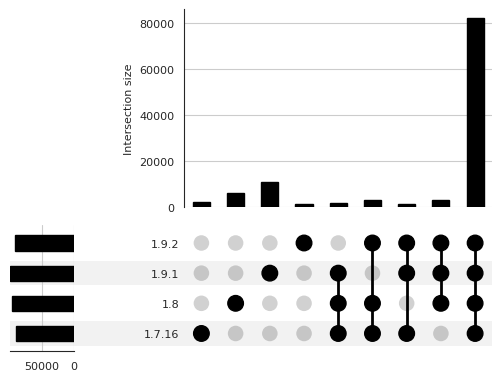

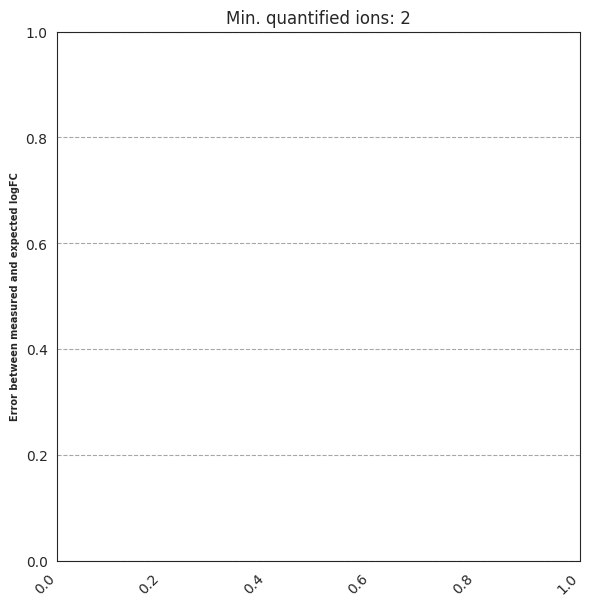

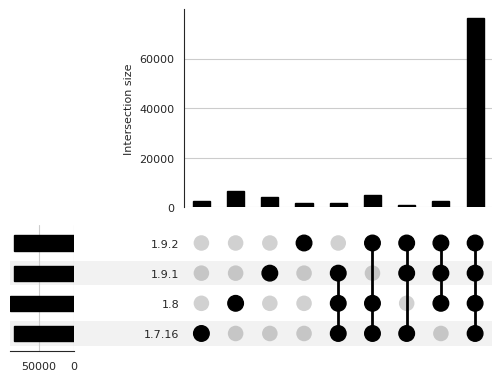

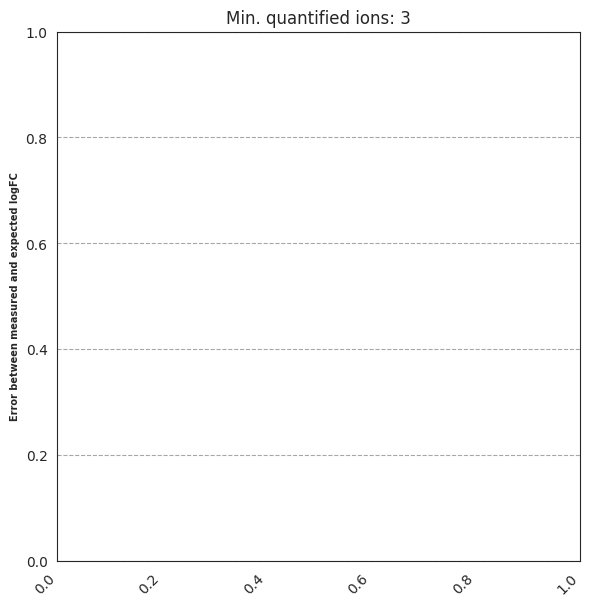

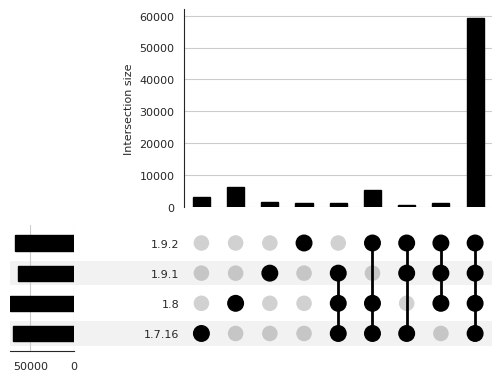

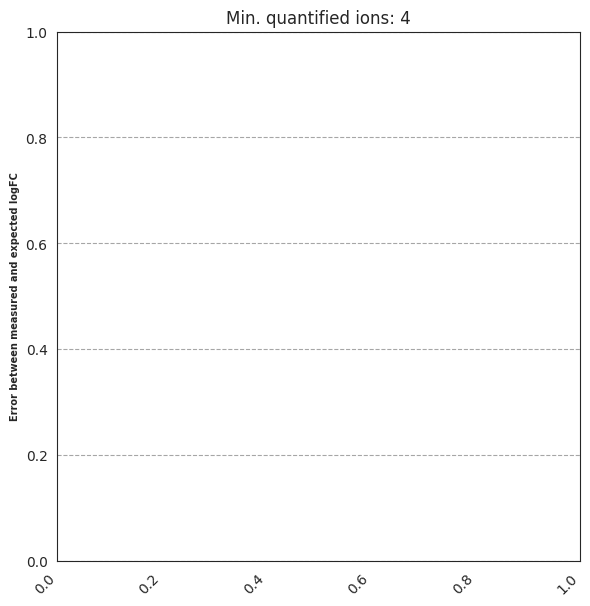

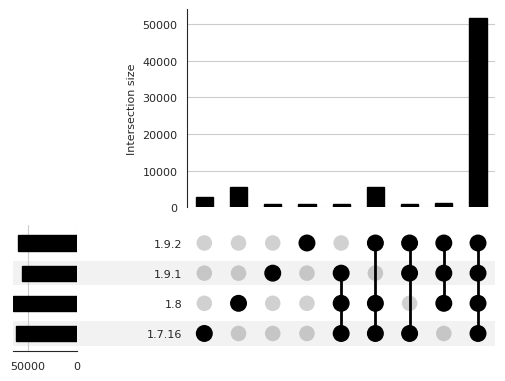

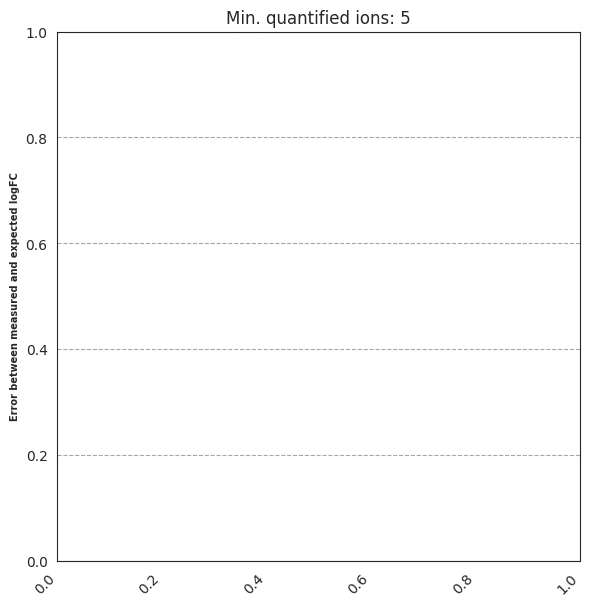

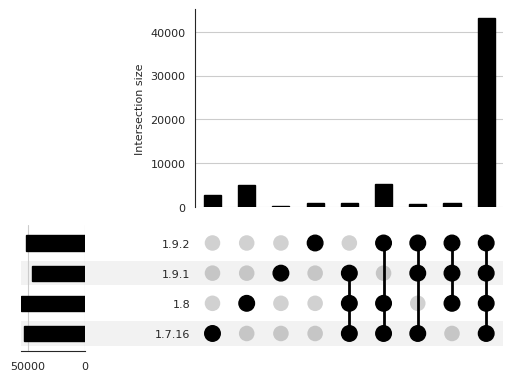

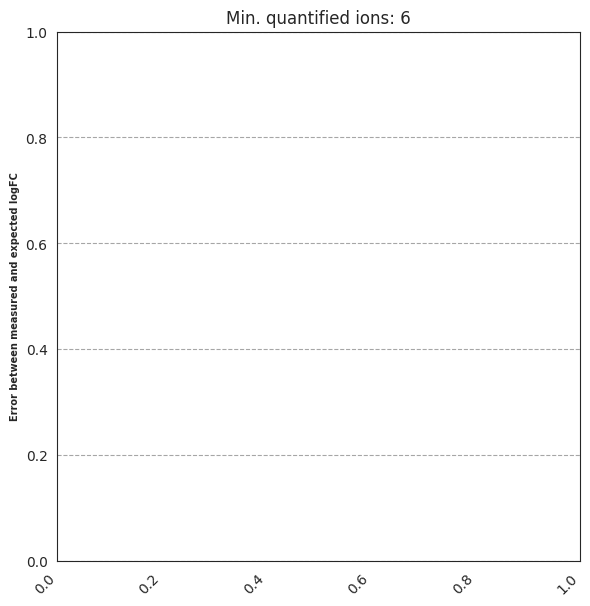

In [48]:
version_mapper = {
    "[False, False, True, False]": "DIA-NN 1.9.1",
    "[False, True, False, False]": "DIA-NN 1.8",
    "[False, False, False, True]": "DIA-NN 1.9.2",
    "[True, False, False, False]": "DIA-NN 1.7.16",
    "[False, True, True, True]": "all but DIA-NN 1.7.16",
    "[True, True, True, False]": "all but DIA-NN 1.9.2",
    "[True, False, True, True]": "all but DIA-NN 1.8",
    "[True, True, False, True]": "all but DIA-NN 1.9.1",
    "[True, True, True, True]": "all",
}

fig = plot_upset_and_boxplot_all_filters(performance_df_dict_versioning, version_mapper)

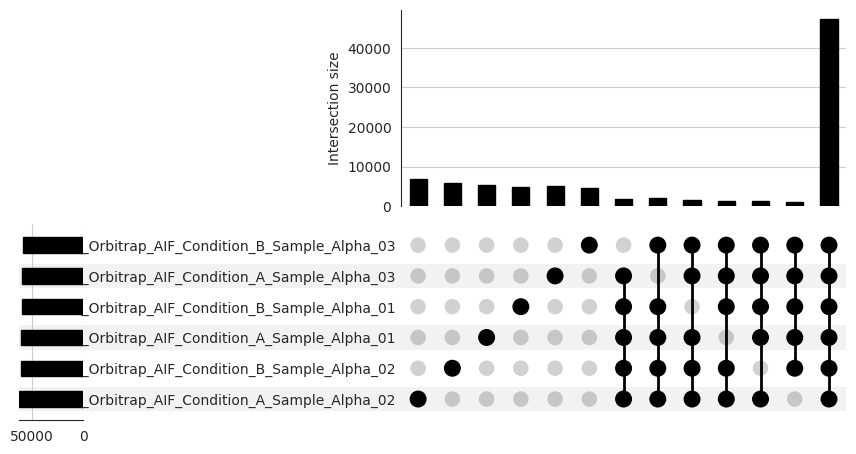

In [49]:
plot_quant_prec_overlap_files(performance_df_dict_versioning["1.9.1"])

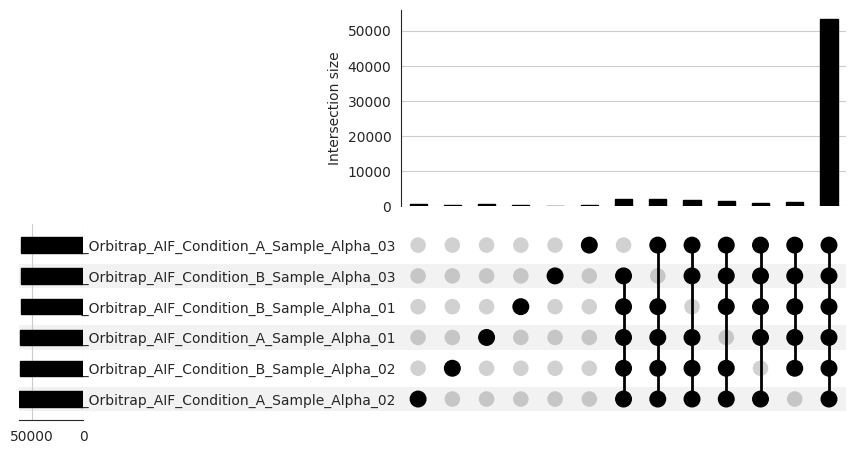

In [50]:
plot_quant_prec_overlap_files(performance_df_dict_versioning["1.9.2"])

# Spectronaut: differences between versions

In [180]:
# file_paths_spectronaut_versioning = {
#     "Spectronaut": {
#         "19.0": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_0/Experiment1_Report_BGS Factory Report (Normal).tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_0/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
#         ),
#         "19.1": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_1/Experiment1_Report_BGS Factory Report (Normal).tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_1/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
#         ),
#         "19.2": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_2/Experiment1_Report_BGS Factory Report (Normal).tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_2/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
#         ),
#         "19.4": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_Report_BGS Factory Report (Normal).tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/spectronaut_19_4/Experiment1_ExperimentSetupOverview_BGS Factory Settings.txt",
#         ),
#     }
# }

In [181]:
# plot, results_spectronaut = plot_performance_metrics_all_filters(
#     file_paths_spectronaut_versioning,
# )
# plot

# DIA-NN 1.9.2: FDR control methods

In [182]:
file_paths_fdr = {
    "DIA-NN": {
        "Single NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_singlepassnn_secondtry/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_singlepassnn_secondtry/report.logsinglepass.txt",
        ),
        "Double NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_doublepassnn_second_try/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_doublepassnn_second_try/report_doublepass.log.txt",
        ),
        "Conservative NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_conservativenn/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_conservativenn/report.log.txt",
        ),
        "Linear NN": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_linearclassifier/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_linearclassifier/report.log.txt",
        ),
    }
}

In [183]:
plot, results_fdr = plot_performance_metrics_all_filters(file_paths_fdr, x_range=[0.1, 0.24], y_range=[0, 100000])
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Skipping Double NN as no new datapoint was added.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [184]:
plot, results_fdr = plot_performance_metrics_all_filters(
    file_paths_fdr, x_range=[0.4, 0.60], y_range=[0, 100000], metric="Mean"
)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Skipping Double NN as no new datapoint was added.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [185]:
performance_df_dict_fdr = prepare_performance_dict(results_fdr)
# combined_species_plots(performance_df_dict_fdr)

In [186]:
performance_df_dict_fdr.pop("Double NN")

,precursor ion,log_Intensity_mean_A,log_Intensity_mean_B,log_Intensity_std_A,log_Intensity_std_B,Intensity_mean_A,Intensity_mean_B,Intensity_std_A,Intensity_std_B,CV_A,...,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_02,LFQ_Orbitrap_AIF_Condition_B_Sample_Alpha_03,nr_observed,YEAST,ECOLI,HUMAN,unique,species,log2_expectedRatio,epsilon
0,AAAAAAALQAK|Z=1,20.952739,21.036922,0.477874,0.244751,2.099827e+06,2.172067e+06,6.213179e+05,3.634753e+05,0.295890,...,2531050.0,2180890.0,6,False,False,True,1,HUMAN,0.0,-0.084183
1,AAAAAAALQAK|Z=2,27.030010,27.140637,0.720669,0.802504,1.475627e+08,1.621295e+08,6.117862e+07,7.462612e+07,0.414594,...,221843000.0,78469600.0,6,False,False,True,1,HUMAN,0.0,-0.110627
2,AAAAAATAPPSPGPAQPGPR|Z=2,18.982668,18.952280,0.208855,0.062666,5.216210e+05,5.075477e+05,7.433748e+04,2.193243e+04,0.142512,...,484232.0,510643.0,6,False,False,True,1,HUMAN,0.0,0.030389
3,AAAAADLANR|Z=2,21.549036,21.514555,1.061618,0.871649,3.570910e+06,3.336117e+06,1.992393e+06,1.663103e+06,0.557951,...,3723440.0,1513530.0,6,False,False,True,1,HUMAN,0.0,0.034480
4,AAAAALSQQQSLQER|Z=2,18.363518,18.461842,0.141676,0.167711,3.383293e+05,3.626570e+05,3.228531e+04,4.122947e+04,0.095426,...,371594.0,398685.0,6,False,False,True,1,HUMAN,0.0,-0.098325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97967,[Acetyl]-VEEVQK|Z=1,22.156982,21.911880,0.069881,0.108550,4.680130e+06,3.953163e+06,2.288766e+05,2.931538e+05,0.048904,...,3631230.0,4204730.0,6,True,False,False,1,YEAST,1.0,-0.754898
97968,[Acetyl]-VHFTAEEK|Z=2,22.012581,22.309747,0.645634,0.390964,4.495743e+06,5.323640e+06,1.731725e+06,1.376190e+06,0.385192,...,5476000.0,3877610.0,6,False,False,True,1,HUMAN,0.0,-0.297166
97969,[Acetyl]-VLVQDLLHPTAASEAR|Z=2,22.347264,21.183276,0.662848,0.177394,5.704040e+06,2.393093e+06,2.420583e+06,2.880447e+05,0.424363,...,2651030.0,2445980.0,6,True,False,False,1,YEAST,1.0,0.163987
97970,[Acetyl]-VNFTVDQIR|Z=2,19.751101,19.586919,0.418421,1.616503,9.060670e+05,1.047872e+06,2.399651e+05,9.776296e+05,0.264843,...,1739160.0,356583.0,5,False,False,True,1,HUMAN,0.0,0.164182


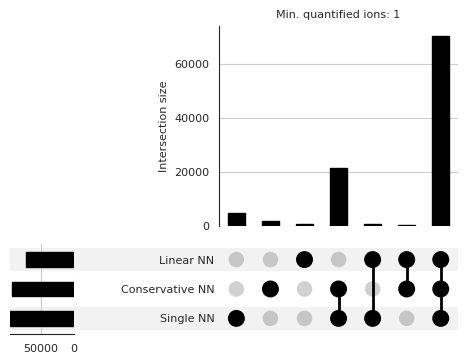

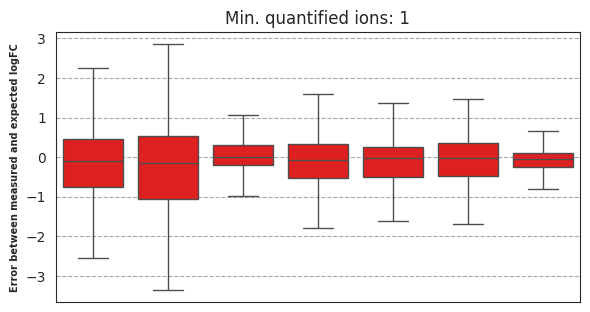

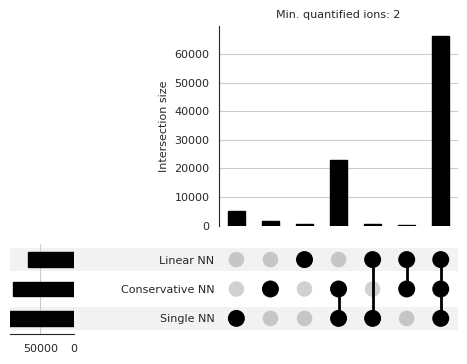

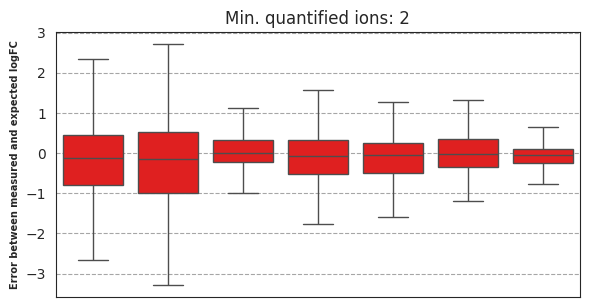

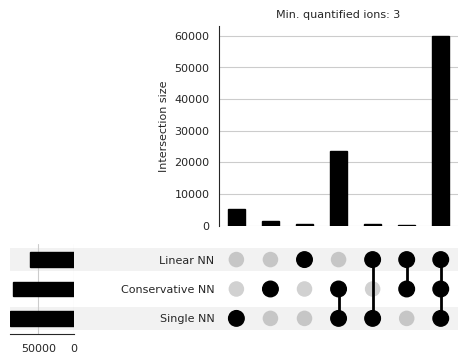

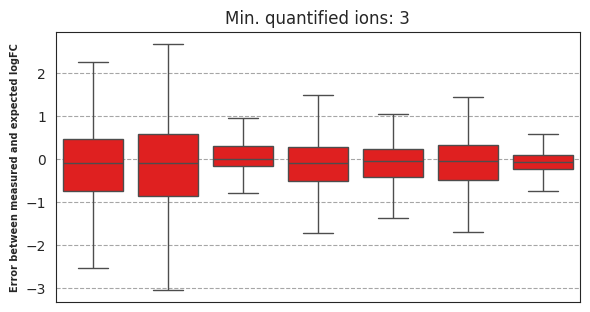

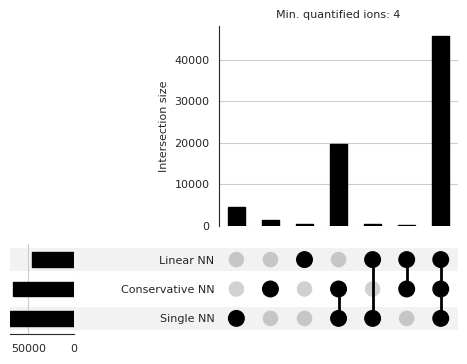

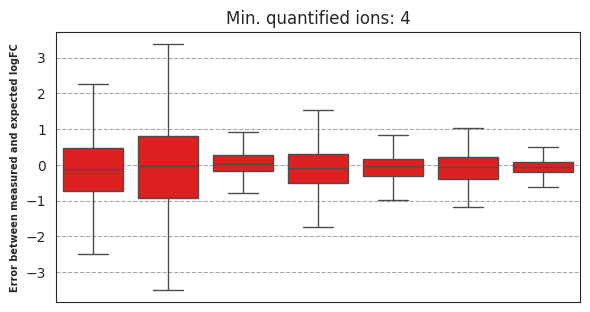

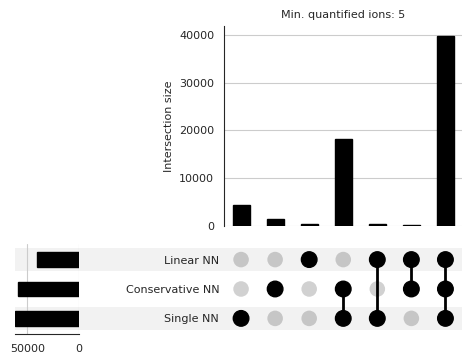

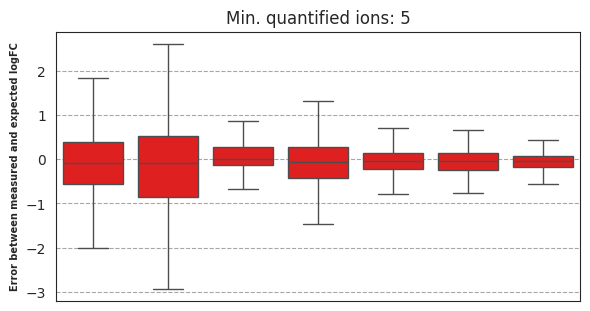

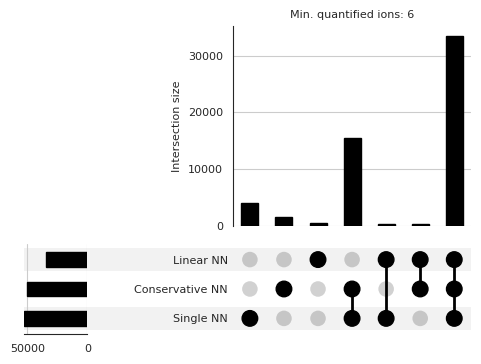

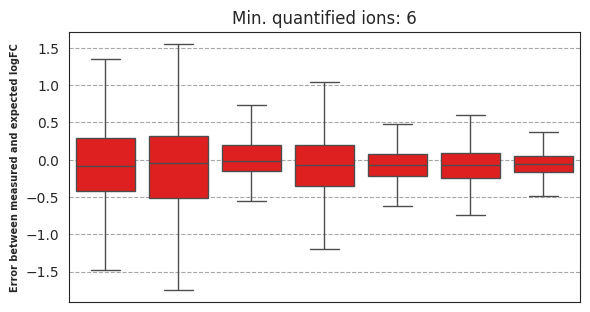

In [187]:
fdr_mapper = {
    "[True, False, False]": "DIA-NN single neural network",
    "[False, True, False]": "DIA-NN conservative neural network",
    "[False, False, True]": "DIA-NN linear classifier",
    "[True, True, False]": "all but DIA-NN linear classifier",
    "[True, False, True]": "all but DIA-NN conservative neural network",
    "[False, True, True]": "all but DIA-NN single neural network",
    "[True, True, True]": "all",
}

fig = plot_upset_and_boxplot_all_filters(performance_df_dict_fdr, fdr_mapper)

# DIA-NN 1.9.2.: Different quantification strategies

In [58]:
file_paths_quant = {
    "DIA-NN": {
        "High Precision": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
        ),
        "High Accuracy": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_highacc/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_highacc/report.log.txt",
        ),
        "Legacy Quant": (
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_legacy_quant/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_legacy_quant/report.log.txt",
        ),
    }
}

In [59]:
plot, results_quant = plot_performance_metrics(file_paths_quant, metric="Median")

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [61]:
plot.write_image("/mnt/c/Users/robbe/Work/ProteoBench/figures_manuscript/quant_performance_metrics_AIF.svg")

In [244]:
plot, results_quant = plot_performance_metrics_all_filters(file_paths_quant, x_range=[0.1, 0.24], y_range=[0, 120000])
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [190]:
performance_df_dict_quant = prepare_performance_dict(results_quant)
# combined_species_plots(performance_df_dict_quant)

In [191]:
# TODO: find a reason for the quant differences, e.g. plot Intensity vs epsilon

# Comparison with diaPASEF

In [51]:
from proteobench.modules.quant.lfq.ion.DIA.quant_lfq_ion_DIA_diaPASEF import DIAQuantIonModulediaPASEF

diapasef_module = DIAQuantIonModulediaPASEF("token")

In [52]:
file_paths_quant_diaPASEF = {
    "DIA-NN": {
        "High Precision": (
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_default/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_default/report.log.txt",
        ),
        "High Accuracy": (
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_highacc/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_highacc/report.log.txt",
        ),
        "Legacy Quant": (
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_legacyquant/report.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output_diaPASEF/diann_1.9.2_legacyquant/report.log.txt",
        ),
    }
}

In [55]:
plot, results_quant_diaPASEF = plot_performance_metrics(
    file_paths_quant_diaPASEF, module=diapasef_module, metric="Median"
)

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [57]:
plot.write_image("/mnt/c/Users/robbe/Work/ProteoBench/figures_manuscript/quant_performance_metrics_diaPASEF.svg")

In [53]:
plot, results_quant_diaPASEF = plot_performance_metrics_all_filters(
    file_paths_quant_diaPASEF, x_range=[0.12, 0.15], y_range=[0, 120000], module=diapasef_module
)

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [54]:
plot

# DIA-NN: different library options

In [196]:
# file_path_library = {
#     "DIA-NN": {
#         "In-Built": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_default/report.log.txt",
#         ),
#         "Carafe": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_carafe_lib/report.tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_carafe_lib/report.log.txt",
#         ),
#         "GPF": (
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_GP_lib/report.tsv",
#             "/mnt/d/Proteobench_manuscript_data/run_output/diann_1.9.2_GP_lib/report.log.txt",
#         ),
#     }
# }

In [197]:
# plot, results_library = plot_performance_metrics(file_path_library)
# plot

In [198]:
# performance_df_dict_library = prepare_performance_dict(results_library)
# combined_species_plots(performance_df_dict_library)

In [199]:
# %matplotlib inline
# library_mapper = {
#     "[False, True, False]": "Carafe library",
#     "[False, False, True]": "GP library",
#     "[True, False, False]": "DIA-NN inbuilt library",
#     "[False, True, True]": "all but DIA-NN inbuilt library",
#     "[True, True, False]": "all but GP library",
#     "[True, False, True]": "all but Carafe library",
#     "[True, True, True]": "all",
# }

# fig = plot_upset_and_boxplot(performance_df_dict_library, library_mapper)

# Different MSAID quant options

In [203]:
file_paths_msaid = {
    "MSAID": {
        "MS1 apex": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_apex/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_apex/Proteobench_MS1_apex_details.csv",
        ),
        "MS2 apex": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex/Proteobench_MS2_apex_details.csv",
        ),
        "MS2 area": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_area/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_area/Proteobench_MS2_area_details.csv",
        ),
        "MS1 area": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_area/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS1_area/Proteobench_MS1_area_details.csv",
        ),
        "MS2 apex (in all files)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex_in_all_files/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_MS2_apex_in_all_files/Proteobench_MS2_apex_quan_in_all_files_details.csv",
        ),
        "MS2 area (in all files)": (
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/precursors_with_headers.tsv",
            "/mnt/d/Proteobench_manuscript_data/run_output/MSAID_default/Proteobench_default_actual_details.csv",
        ),
    }
}

In [204]:
plot, results_msaid = plot_performance_metrics(file_paths_msaid)
plot

Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.
Not all columns required for making the ion are available.


In [202]:
# performance_df_dict_msaid = prepare_performance_dict(results_msaid, mapper="MSAID")
# combined_species_plots(performance_df_dict_msaid)